In [152]:
import pandas as pd
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import re
from patsy import dmatrices

from sklearn import linear_model as lm
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from IPython.display import Image

from sklearn import datasets
from sklearn.decomposition import PCA

In [3]:
ccdf = pd.read_csv('cc_data.csv')

In [209]:
ccdf.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default',
       'HIGHSCHOOL', 'UNIVERSITY', 'GRADUATE'],
      dtype='object')

In [5]:
ccdf = ccdf.rename(columns={'default payment next month': 'default'})

In [6]:
ccdf.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [210]:
ccdf.groupby('default')['default'].count()

default
0    22649
1     6514
Name: default, dtype: int64

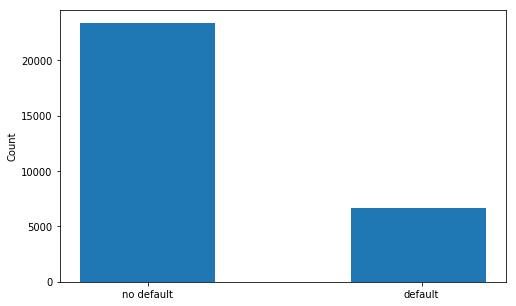

In [9]:
plt.figure(figsize = (8,5))
plt.hist(ccdf['default'], bins = 3 , align = 'left');
plt.xticks([0,.675], ['no default', 'default']);
plt.ylabel('Count');

As we can see from the histogram above, the data is somewhat skewed. There are 6636 card holders in default and 23364 card holders not in default.

In [10]:
ccdf['SEX'] = ccdf['SEX'] - 1

In [15]:
ccdf.groupby('EDUCATION')['EDUCATION'].count()

EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: EDUCATION, dtype: int64

In [16]:
ccdf.groupby('MARRIAGE')['MARRIAGE'].count()

MARRIAGE
0       54
1    13659
2    15964
3      323
Name: MARRIAGE, dtype: int64

In [18]:
#Need to drop the rows with marriage = 0 or 3. Then I can make Marriage a dummy variable. 
#Need to drop the rows with education = 0,4,5,6.  
ccdf = ccdf[ccdf['MARRIAGE'] > 0]
ccdf = ccdf[ccdf['MARRIAGE'] < 3]
ccdf = ccdf[ccdf['EDUCATION'] < 4]
ccdf = ccdf[ccdf['EDUCATION'] > 0]

In [19]:
ccdf.groupby('MARRIAGE')['MARRIAGE'].count()

MARRIAGE
1    13425
2    15738
Name: MARRIAGE, dtype: int64

In [20]:
ccdf['MARRIAGE'] = ccdf['MARRIAGE'] - 1

In [21]:
ccdf.groupby('MARRIAGE')['MARRIAGE'].count()

MARRIAGE
0    13425
1    15738
Name: MARRIAGE, dtype: int64

In [22]:
ccdf.groupby('EDUCATION')['EDUCATION'].count()

EDUCATION
1    10531
2    13862
3     4770
Name: EDUCATION, dtype: int64

In [23]:
ccdf['EDUCATION'] = ccdf['EDUCATION'] - 1

In [24]:
ccdf.groupby('EDUCATION')['EDUCATION'].count()

EDUCATION
0    10531
1    13862
2     4770
Name: EDUCATION, dtype: int64

In [193]:
ccdf['BILL_AMT1']

0          3913
1          2682
2         29239
3         46990
4          8617
5         64400
6        367965
7         11876
8         11285
9             0
10        11073
11        12261
12        12137
13        65802
14        70887
15        15376
16       253286
17            0
18            0
19        38358
20          316
21        41087
22         5512
23         4744
24        47620
25         -109
26        22541
27          650
28        15329
29        16646
          ...  
29133     33654
29134     65554
29135     21628
29136         0
29137     10904
29138     45075
29139     52358
29140    131939
29141    238973
29142         0
29143     43998
29144     38671
29145      7752
29146      1822
29147       315
29148         0
29149      2220
29150     23292
29151    279640
29152      3425
29153    138325
29154      2500
29155      8802
29156      3042
29157     72557
29158    188948
29159      1683
29160      3565
29161     -1645
29162     47929
Name: BILL_AMT1, Length:

In [44]:
ccdf['EDUCATION'][3]

1

In [47]:
#Now that we have our variables cleaned we need to combine them to create a bunch of dummy variables.
#We need interaction variables for every different dummy variable.
#Since Education still has three lets split this into 3 different dummy variables before we can create interaction
#terms in a maeaningful way.
ccdf = ccdf.reset_index(drop=True)
ccdf['HIGHSCHOOL'] = 0
ccdf['UNIVERSITY'] = 0
ccdf['GRADUATE'] = 0
i = 0
while i < len(ccdf):
    if ccdf['EDUCATION'][i] == 2:
        ccdf['HIGHSCHOOL'][i] = 1
        i = i + 1
    elif ccdf['EDUCATION'][i] == 1:
        ccdf['UNIVERSITY'][i] = 1
        i = i + 1
    else:
        ccdf['GRADUATE'][i] = 1
        i = i + 1
        

In [192]:
ccdf.to_pickle('ccdf.pkl')

In [194]:
X = ccdf.drop(['ID','default','EDUCATION', 'PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5'],1)
y = ccdf['default']
#,'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'
#,'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6'

In [195]:
X['INTERCEPT'] = 1

In [196]:
ccdf.corr()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,HIGHSCHOOL,UNIVERSITY,GRADUATE
ID,1.000000,0.023510,0.020164,0.027405,-0.024537,0.020221,-0.028784,-0.008455,-0.016598,-0.000475,...,0.006800,0.005234,0.037839,0.005645,-0.000144,0.003334,-0.013733,0.021397,0.006548,-0.023285
LIMIT_BAL,0.023510,1.000000,0.023998,-0.252313,-0.097990,0.151659,-0.271805,-0.296506,-0.286411,-0.267142,...,0.203309,0.184230,0.218472,0.207093,0.217608,0.219672,-0.153576,-0.137188,-0.148876,0.260429
SEX,0.020164,0.023998,1.000000,0.009496,-0.031002,-0.092140,-0.057736,-0.071585,-0.067356,-0.060794,...,-0.001315,-0.002467,-0.010414,-0.003920,-0.002545,-0.002903,-0.038963,-0.009238,0.026935,-0.020891
EDUCATION,0.027405,-0.252313,0.009496,1.000000,-0.176812,0.190031,0.131852,0.153145,0.145888,0.138315,...,-0.046522,-0.038815,-0.056536,-0.043445,-0.051002,-0.052782,0.055502,0.759902,0.269810,-0.865696
MARRIAGE,-0.024537,-0.097990,-0.031002,-0.176812,1.000000,-0.466317,0.013459,0.020416,0.028451,0.028490,...,-0.008513,-0.012045,-0.004702,-0.015865,-0.002078,-0.003275,-0.031437,-0.123719,-0.063469,0.161260
AGE,0.020221,0.151659,-0.092140,0.190031,-0.466317,1.000000,-0.043073,-0.052536,-0.055635,-0.052879,...,0.027231,0.023498,0.031199,0.022434,0.021620,0.021064,0.012983,0.230817,-0.076732,-0.097966
PAY_0,-0.028784,-0.271805,-0.057736,0.131852,0.013459,-0.043073,1.000000,0.672171,0.574688,0.539288,...,-0.082783,-0.072192,-0.072291,-0.065018,-0.061068,-0.060142,0.327230,0.057898,0.098230,-0.146715
PAY_2,-0.008455,-0.296506,-0.071585,0.153145,0.020416,-0.052536,0.672171,1.000000,0.766798,0.662358,...,-0.084396,-0.060314,-0.057200,-0.047851,-0.039800,-0.037402,0.263981,0.062868,0.120582,-0.173781
PAY_3,-0.016598,-0.286411,-0.067356,0.145888,0.028451,-0.055635,0.574688,0.766798,1.000000,0.777441,...,0.002654,-0.068884,-0.054217,-0.046627,-0.036294,-0.036782,0.234362,0.060734,0.113616,-0.164896
PAY_4,-0.000475,-0.267142,-0.060794,0.138315,0.028490,-0.052879,0.539288,0.662358,0.777441,1.000000,...,-0.008689,-0.000999,-0.071149,-0.044134,-0.033287,-0.027536,0.214627,0.057538,0.107783,-0.156369


In [197]:
X

,LIMIT_BAL,SEX,MARRIAGE,AGE,BILL_AMT1,BILL_AMT6,PAY_AMT1,PAY_AMT6,HIGHSCHOOL,UNIVERSITY,GRADUATE,INTERCEPT
0,20000,1,0,24,3913,0,0,0,0,1,0,1
1,120000,1,1,26,2682,3261,0,2000,0,1,0,1
2,90000,1,1,34,29239,15549,1518,5000,0,1,0,1
3,50000,1,0,37,46990,29547,2000,1000,0,1,0,1
4,50000,0,0,57,8617,19131,2000,679,0,1,0,1
5,50000,0,1,37,64400,20024,2500,800,0,0,1,1
6,500000,0,1,29,367965,473944,55000,13770,0,0,1,1
7,100000,1,1,23,11876,567,380,1542,0,1,0,1
8,140000,1,0,28,11285,3719,3329,1000,1,0,0,1
9,20000,0,1,35,0,13912,0,0,1,0,0,1


In [117]:
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [118]:
def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.3, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

Training Data Accuracy: 0.77
Test Data Accuracy:     0.78
[[6863    0]
 [1886    0]]


Precision:              0.78
Recall:                 1.00


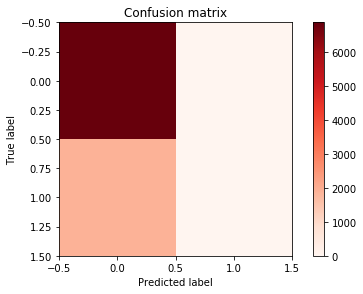

In [198]:
log_clf=LogisticRegression()
train_score(log_clf,X,y)

Text(0,0.5,'TPR')

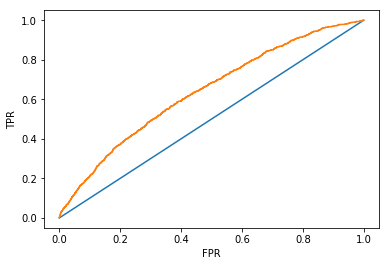

In [199]:
# What about ROC ? 

from sklearn.metrics import roc_curve, auc

xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)
log = LogisticRegression()
log.fit(xtrain,np.ravel(ytrain))
y_score=log.predict_proba(xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [200]:
log.coef_

array([[ -4.77713207e-06,  -1.75329223e-04,  -2.12962536e-04,
         -7.16242894e-03,  -1.48471186e-06,   3.70834622e-06,
         -4.12401408e-05,  -5.23255861e-06,  -4.57283728e-05,
         -1.39544590e-04,  -6.04294389e-05,  -2.45702402e-04]])

In [59]:
#Now that the new columns are added we can drop the education column and create our interaction variables.
interaction = ccdf[['SEX', 'MARRIAGE', 'HIGHSCHOOL', 'UNIVERSITY', 'GRADUATE']]
interdf = PolynomialFeatures(1, interaction_only=True, include_bias=False).fit_transform(ccdf)


In [151]:
#plt.hist(y)
log.predict_proba(X)

array([[ 0.62022148,  0.37977852],
       [ 0.71593444,  0.28406556],
       [ 0.7161625 ,  0.2838375 ],
       ..., 
       [ 0.67991703,  0.32008297],
       [ 0.73564169,  0.26435831],
       [ 0.72295035,  0.27704965]])

In [154]:
from sklearn.cross_validation import train_test_split

def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

linearsvc = LinearSVC()
# Do the test 10 times with a LinearSVC and get the average score
quick_test_afew_times(linearsvc, X, y)

0.67634015316036111

In [201]:
randomforest = RandomForestClassifier()
quick_test_afew_times(randomforest, X, y)

0.76667047662590004

Training Data Accuracy: 0.98
Test Data Accuracy:     0.77
[[6468  395]
 [1598  288]]


Precision:              0.80
Recall:                 0.94


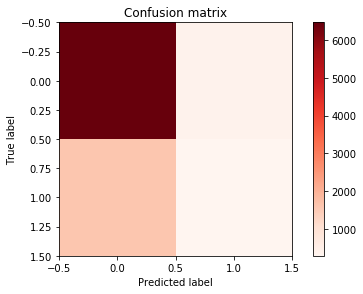

In [202]:
train_score(randomforest,X,y)

In [203]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
y_pred = knn.predict(X)


print(metrics.accuracy_score(y, y_pred))

0.817371326681


In [204]:
# STEP 1: split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [205]:
# Train on training set, and Test on testing set
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.777472998457


Training Data Accuracy: 0.78
Test Data Accuracy:     0.78
[[6704  159]
 [1738  148]]


Precision:              0.79
Recall:                 0.98


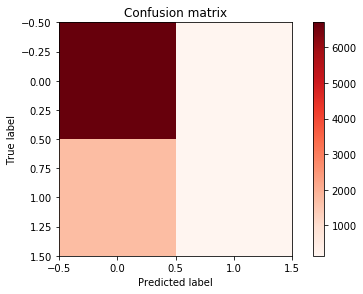

In [206]:
train_score(knn,X,y)

In [188]:
from sklearn.model_selection import cross_val_score
# search for an optimal value of K for KNN
k_range = list(range(1, 35))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.69289992271389067, 0.76377667993222087, 0.73583074918383706, 0.76892014864948655, 0.75462155907752537, 0.7695029861650976, 0.76192508658505487, 0.77087464604698808, 0.7655940382990839, 0.772040344639499, 0.76874873958699419, 0.77382340954227802, 0.76946861026876678, 0.77509200054160476, 0.77152614116656792, 0.77502348399078858, 0.77293171829820662, 0.77646367218800738, 0.77454358592390971, 0.77725220053021227, 0.77447497528926124, 0.77756091309259356, 0.77642947271096152, 0.77769801674096761, 0.7763609562085424, 0.77749242007886787, 0.77742380942002087, 0.77790375456108052, 0.77680647837102434, 0.77817802071265407, 0.77684068967711184, 0.77828090137109018, 0.7771494022072285, 0.7781437271437095]


Text(0,0.5,'Cross-Validated Accuracy')

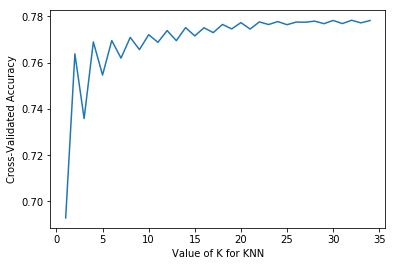

In [189]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [207]:
#All of my models seem to be getting very high false positive rates.  Additionally, when the model actually picks
#That there will be a default it is correct only about half of the time.  Consider adjusting the sample to create a 
#more balanced data set between default and not default.